<a href="https://colab.research.google.com/github/uprestel/AutoNeRF/blob/master/pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoNeRF Implementation
In this Notebook we 
* train a VAE on synthetic NeRF data
* train a cINN on the same dataset
* combine the two models to generate novel views




### Load imports

In [ ]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

!git clone https://github.com/uprestel/AutoNeRF.git

import AutoNeRF.data.data
import AutoNeRF.models.cinn as cinn
import AutoNeRF.models.blocks as blocks
import AutoNeRF.models.loss as cinn_loss
import AutoNeRF.models.nerf as nerf
import AutoNeRF.models.vae
import AutoNeRF.util.utils
#import AutoNeRF.cam_util
from AutoNeRF.util.transforms import random_rotation, look_at_rotation

import time
import os
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt


import numpy as np
#import plotly.graph_objects as go

#import pytorch3d
#from pytorch3d.transforms import random_rotation
#from pytorch3d.renderer.cameras import look_at_rotation

from google.colab import drive
drive.mount('/gdrive', force_remount=True)


fatal: destination path 'AutoNeRF' already exists and is not an empty directory.
Mounted at /gdrive


## Determine device to run on (GPU vs CPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load trained NeRF model

In [ ]:
model = nerf.TinyNerfModel().to(device)
model.load_state_dict(torch.load("/gdrive/My Drive/nerf_lego.pt"))
model.eval()

TinyNerfModel(
  (layer1): Linear(in_features=39, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=4, bias=True)
)

In [ ]:
torch.save(vaenc.state_dict(), "/gdrive/My Drive/vae_lego.pt")

## cINN training
Now that our VAE is ready, we are now learning a normalizing flow to generate new samples

In [ ]:
latent_space = 64
batch_size = 32
epochs = 40

#tau = cinn.ConditionalTransformer(
#    in_channels = latent_space,
#    cond_channels = 12,
#    hidden_dim = 128,
#    hidden_depth = 4,
#    n_flows = 12
#).to(device)

# OPTIMIZER: AMSGRAD OR ADAM WITH 1e-2
optimizer = torch.optim.Adam(params=tau.parameters(), lr=1e-4)

#vae = AutoNeRF.vae.VAE(in_channels = 3, latent_dim=latent_space).to(device)
#vae.load_state_dict(torch.load("/gdrive/My Drive/vae_lego.pt"))
#vae.eval()


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
loss = cinn_loss.Loss(None)

for epoch in range(epochs):
    print("--- starting epoch %s ---"%epoch)
    for i, sample in enumerate(dataloader):
        optimizer.zero_grad()

        images, poses = sample
        images = transform(images).to(device)

        c_poses = poses.view(batch_size, -1)
        c_poses_red = c_poses[:, :12].to(device)

        _,_,_,z = vaenc(images)
        
        z = z[:,:,None,None]
        c_poses_red = c_poses_red[:,:,None,None]


        zz, logdet = tau(z,c_poses_red)
        l = loss(zz, logdet)
        l.backward()

        optimizer.step()
        if i % 100 == 0:
            print(l.item())

        
    



In [ ]:
torch.save(tau.state_dict(), "/gdrive/My Drive/cinn_lego.pt")

In [ ]:

latent_space=64
tau = cinn.ConditionalTransformer(
    in_channels = latent_space,
    cond_channels = 12,
    hidden_dim = 128,
    hidden_depth = 4,
    n_flows = 12
).to(device)
tau.load_state_dict(torch.load("/gdrive/My Drive/cinn_lego.pt"))
tau.eval()


vaenc = AutoNeRF.models.vae.VAE(in_channels = 3, latent_dim=latent_space).to(device)
vaenc.load_state_dict(torch.load("/gdrive/My Drive/vae_lego.pt"))
vaenc.eval()


torch.Size([1, 64])


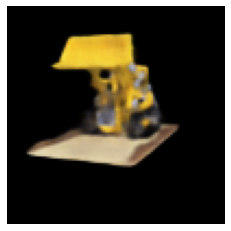

In [ ]:
batch_size=1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

with torch.no_grad():
    for i, sample in enumerate(dataloader):

        images, poses = sample
        
        c_poses = poses.view(batch_size, -1)
        c_poses_red = c_poses[:, :12].to(device)
        c_poses_red = c_poses_red[:,:,None,None]

        #_,_,_,z = vae(images)
        zz = torch.randn(batch_size, latent_space).to(device)
        zz = zz[:,:, None, None]
        z = tau.reverse(zz, c_poses_red).squeeze(-1).squeeze(-1)
        print(z.shape)
        images = vaenc.decode(z)
        show(images.cpu())
        break

In [ ]:
translation = torch.tensor(dataset.poses[:, :3,3]).to(device)

center = torch.zeros(3).to(device)
radius = torch.norm(translation[0] - center, p=2)

print(radius, center)

SCENE_RADIUS = 2


def get_thresholds(r):
    diff = r - SCENE_RADIUS
    tn = diff
    tf = diff + 2*SCENE_RADIUS
    return tn, tf


def get_new_random_pose(center, radius):
    """
    generates a new pose / perspective for the NeRF model
    """

    rot = random_rotation().to(device)
    unit_x = torch.tensor([1.,0.,0.]).to(device)
    new_t = center + radius*(rot @ unit_x)

    new_t[2] = torch.abs(new_t[2])

    up = torch.tensor([0.,0.,1.]).unsqueeze(dim=0).to(device)

    #print(new_t)
    #print(new_t.shape, center.shape)
    #print(type(new_t), type(center))
    cam_rot = look_at_rotation(at=new_t.unsqueeze(dim=0), 
                               camera_position=center.unsqueeze(dim=0),up=up) #tform_cam2world[0, :3, :3]#

    #cam_rot[0,2] = 0
    #print(cam_rot, "sss")
    

    #cam_rot = torch.transpose(cam_rot, 1,2)
    transform = torch.zeros((4,4))#.to(device)
    
    transform[:3, :3] = cam_rot
    transform[:3, 3] = new_t
    transform[3, 3] = 1
    #print(look_at_rotation(center))
    return transform

tensor(3.0827, device='cuda:0') tensor([0., 0., 0.], device='cuda:0')


In [ ]:
from pytorch3d.renderer.cameras import look_at_view_transform
from math import radians, sqrt

batch_size=1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)


def show(image, dpi=10, permutation=(1,2,0), **kwargs):
    grid_img = torchvision.utils.make_grid(image, **kwargs)
    print(grid_img.shape)
    plt.imshow(grid_img.permute(permutation))
    plt.figsize=(30.0, 30.0)
    plt.axis('off')
    plt.show()


def rotx(alpha):
    return torch.tensor([[1,0,0],
                         [0, torch.cos(alpha), -torch.sin(alpha)],
                         [0, torch.sin(alpha), torch.cos(alpha)]])


def roty(alpha):
    return torch.tensor([[torch.cos(alpha), 0, torch.sin(alpha)],
                         [0, 1, 0],
                         [-torch.sin(alpha), 0, torch.cos(alpha)]])


def rotz(alpha):
    #print(alpha.shape, torch.cos(alpha).shape)
    return torch.tensor([[torch.cos(alpha), -torch.sin(alpha), 0],
                         [torch.sin(alpha), torch.cos(alpha), 0],
                         [0, 0, 1]])


def get_new_random_pose(center, radius, alphas):
    """
    generates a new pose / perspective for the NeRF model
    """

    rot = rotz(alphas).to(device)

    unit_x = torch.tensor([1.,0.,.7]).to(device)
    unit_x /= sqrt(1**2 + .7**2)
    new_t = center + radius*(rot @ unit_x) #+ torch.tensor([0., 0., 1.]).to(device)
    new_t[2] = torch.abs(new_t[2])

    up = torch.tensor([0.,0.,1.]).unsqueeze(dim=0).to(device)
    cam_rot = look_at_rotation(at=new_t.unsqueeze(dim=0), 
                               camera_position=center.unsqueeze(dim=0),up=up) 

    transform = torch.zeros((4,4))
    
    transform[:3, :3] = cam_rot
    transform[:3, 3] = new_t
    transform[3, 3] = 1

    return transform


def get_new_parametric_pose(center, radius, alphas):
    """
    generates a new pose / perspective for the NeRF model
    """

    rot = rotz(alphas).to(device)

    unit_x = torch.tensor([1.,0.,.7]).to(device)
    unit_x /= sqrt(1**2 + .7**2)
    new_t = center + radius*(rot @ unit_x) #+ torch.tensor([0., 0., 1.]).to(device)
    new_t[2] = torch.abs(new_t[2])

    up = torch.tensor([0.,0.,1.]).unsqueeze(dim=0).to(device)
    cam_rot = look_at_rotation(at=new_t.unsqueeze(dim=0), 
                               camera_position=center.unsqueeze(dim=0),up=up) 

    transform = torch.zeros((4,4))
    
    transform[:3, :3] = cam_rot
    transform[:3, 3] = new_t
    transform[3, 3] = 1

    return transform





## Render novel views with AutoNeRF

In [ ]:
from math import sin
N = 840

rendered_images = torch.zeros((N, 3, 100, 100))

alphas = torch.linspace(0, radians(360), N)
with torch.no_grad():

    for i, alpha in enumerate(alphas):
        r = radius + .5+ sin(radians(i))
        #print(r)
        poses = get_new_parametric_pose(center, r, alpha).unsqueeze(dim=0)

        #print(nepos.shape)
        c_poses = poses.view(batch_size, -1)
        c_poses_red = c_poses[:, :12].to(device)
        c_poses_red = c_poses_red[:,:,None,None]

        t0 = time.time()
        zz = torch.randn(batch_size, latent_space).to(device)
        zz = zz[:,:, None, None]
    
        z = tau.reverse(zz, c_poses_red).squeeze(-1).squeeze(-1)
        #print(time.time()-t0, "sec for reverse pass")
        images = vaenc.decode(z)
        #print(time.time()-t0, "sec for rendering")
        #show(images.cpu())
        rendered_images[i, :,:,:] = images